In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np 
from numpy.linalg import cholesky 
import matplotlib.pyplot as plt 
from tqdm import tqdm_notebook as tqdm 

In [3]:
import models.l63f as mdl_l63
from models.L63 import l63_jac
from methods.generate_data import generate_data
from methods.LLR_forecasting_CV import m_LLR
from methods.model_forecasting import m_true
from methods.k_choice import k_choice
from methods.CPF_BS_smoothing import _CPF, _CPF_BS
from methods.SEM import CPF_BS_SEM
from methods.npSEM import LLR_CPF_BS_SEM
from methods.regression_2 import regression_2
from methods.EnKS import _EnKS
from save_load import saveTr, loadTr
from methods.additives import RMSE

In [4]:
#%% GENERATE SIMULATED DATA (LORENZ-63 MODEL)
dx = 3 # dimension of the state
dt_int = 0.01 # fixed integration time
dt_model = 8 # chosen number of model time step  \in [1, 25]-the larger dt_model the more nonliner model
var_obs = np.array([0,1,2]) # indices of the observed variables
dy = len(var_obs) # dimension of the observations
H = np.eye(dx)
#H = H[(0,2),:] #  first and third variables are observed
h = lambda x: H.dot(x)  # observation model
jacH = lambda x: H # Jacobian matrix  of the observation model(for EKS_EM only)
sigma = 10.0
rho = 28.0
beta = 8.0/3 # physical parameters
fmdl = mdl_l63.M(sigma=sigma, rho=rho, beta=beta, dtcy= dt_int)
mx = lambda x: fmdl.integ(x) # fortran version (fast)
jac_mx = lambda x: l63_jac(x, dt_int*dt_model, sigma, rho, beta) # python version (slow)

# Setting covariances
sig2_Q = 1; sig2_R = 2 # parameters
Q_true = np.eye(dx) *sig2_Q # model covariance
R_true = np.eye(dx) *sig2_R # observation covariance

# prior state
x0 = np.r_[8, 0, 30]

# generate data
T_burnin = 5*10**3
T_train = 10*10**2 # length of the catalog
T_test = 10*10**2 # length of the testing data
X_train, Y_train, X_test, Y_test, yo = generate_data(x0,mx,h,Q_true,R_true,dt_int,dt_model,var_obs, T_burnin, T_train, T_test) 
X_train.time = np.arange(0,T_train)
Y_train.time= X_train.time[1:]
#np.random.seed(0);# random number generator
N=np.size(Y_train.values);Ngap= np.floor(N/10); # create gaps: 10 percent of missing values
indX=np.random.choice(np.arange(0,N), int(Ngap), replace=False)
ind_gap_taken = divmod(indX ,len(Y_train.time))
Y_train.values[ind_gap_taken]=np.nan

X_train0, Y_train0, X_test0, Y_test0, yo0 = generate_data(X_train.values[:,-1],mx,h,Q_true,R_true,dt_int,dt_model,var_obs, T_burnin, T_train, T_test) 
X_train0.time = np.arange(0,T_train)
Y_train0.time= X_train0.time[1:]

In [5]:
#%% SETTING

class Est:
    pass

estQ = Est()
estQ.value = Q_true
estQ.type = 'adaptive' # chosen predefined type of model error covatiance ('fixed', 'adaptive')
estQ.form = 'constant' # chosen esimated matrix form ('full', 'diag', 'constant')
estQ.base =  np.eye(dx) # for fixed base of model covariance (for 'constant' matrix form only)
estQ.decision = True # chosen if Q is estimated or not ('True', 'False')

estR = Est()
estR.value = R_true
estR.type = 'adaptive' # chosen predefined type of observation error covatiance ('fixed', 'adaptive')
estR.form = 'constant' # chosen esimated matrix form ('full', 'diag', 'constant')
estR.base =  np.eye(dx) # for fixed base of model covariance
estR.decision = True # chosen if R is estimated or not ('True', 'False')
    
estX0 = Est()
estX0.decision = False # chosen if X0 is estimated or not ('True', 'False')
    
estD = Est() # for non-parametric approach only
estD.decision = True # chosen if the smoothed data is updated or not ('True', 'False')


/home/tchau/non_parEMDA/Lorenz63/methods/LLR_forecasting_CV.py:102: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  M = np.linalg.lstsq(Aw.T,Bw.T)[0];


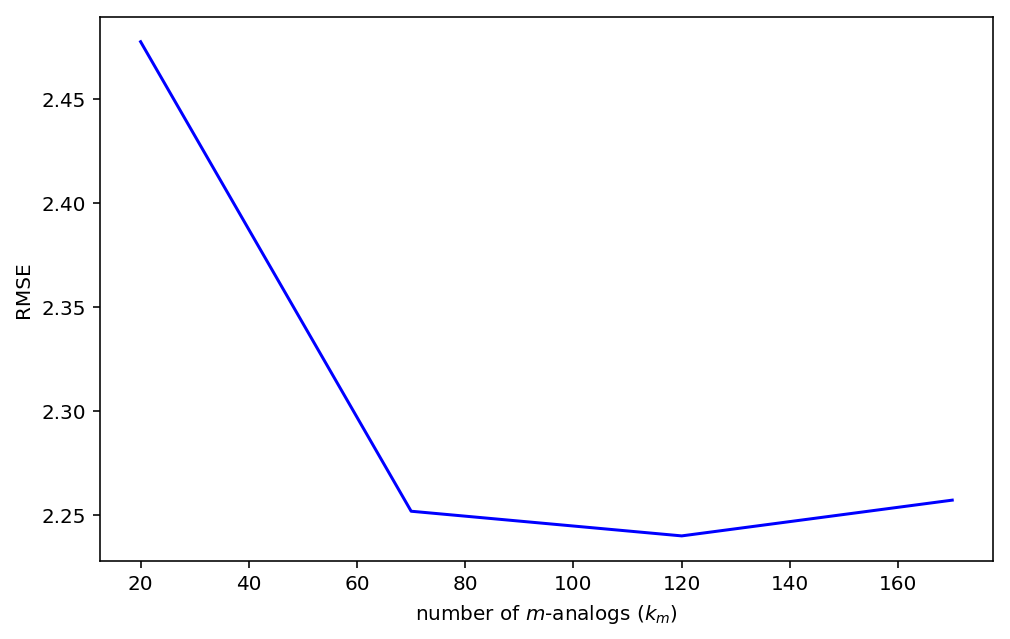

In [6]:
#%% TEST FOR LOCAL LINEAR REGRESSION (LLR_forecasting_CV function)
data_init = np.r_['0,2,0',Y_train.values[...,:-1], Y_train.values[...,1:]]
ind_nogap = np.where(~np.isnan(np.sum(data_init,0)))[0]
num_ana=200
class LLRClass:
    pass

LLR = LLRClass()

class Data:
    "catalog with analogs and successors"
    pass

data = Data()    
data.ana = np.zeros((dx,1,len(ind_nogap)))
data.suc = np.zeros((dx,1,len(ind_nogap)))
data.ana[:,0,:] = data_init[:dx,ind_nogap]
data.suc[:,0,:] = data_init[dx:,ind_nogap]
data.time = Y_train.time[ind_nogap] 

data_prev = Data()
data_prev.ana =data_init[:dx,ind_nogap]
data_prev.suc = data_init[dx:,ind_nogap]
data_prev.time = Y_train.time[ind_nogap] 

LLR.data = data
LLR.data_prev = data_prev
LLR.lag_x = 5 # lag of removed analogs around x to avoid an over-fitting forecast
LLR.lag_Dx = lambda Dx: np.shape(Dx)[-1] #15 lag of moving window of analogs chosen around x 
LLR.time_period = 1 # set 365.25 for year and 
LLR.k_m = [] # number of analogs 
LLR.k_Q = [] # number of analogs 
LLR.nN_m = np.arange(20,num_ana,50) #number of analogs to be chosen for mean estimation
LLR.nN_Q = np.arange(20,num_ana,50) #number of analogs to be chosen for dynamical error covariance
LLR.lag_k = 1 #chosen the lag for k reestimation 
LLR.estK = 'same' # set 'same' if k_m = k_Q chosen, otherwise, set 'different'
LLR.kernel = 'tricube'# set 'rectangular' or 'tricube'
LLR.k_lag = 20
LLR.k_inc= 10
LLR.Q = estQ
LLR.gam = 1

# To choose optimal analogs

k_m, k_Q = k_choice(LLR,LLR.data.ana,LLR.data.suc,LLR.data.time)    #Need to be optimised: paralle runs?
LLR.k_m =k_m; LLR.k_Q =k_Q; #LLR.lag_x = 0



# Forecast with LLR
xf, mean_xf, Q_xf, M_xf = m_LLR(X_test.values[:,:-1],1,np.ones([1]),LLR)  #Need to be optimised


In [7]:
#%% TEST FOR CONDITIONAL PARTICLE FILTERING (_CPF function)
# Here I use the true model  (m) to forecast instead of LLR (m_hat). 
  
m = lambda  x,pos_x,ind_x: m_true(x,pos_x,ind_x,Q_true, mx, jac_mx,dt_model)    
# m_hat = lambda  x,pos_x,ind_x: m_LLR(x,pos_x,ind_x,LLR) 

time = np.arange(T_test-1)#[np.newaxis].T
B = Q_true
xb= X_test.values[...,0]

Nf = 10# number of particles
Ns =5 # number of realizations

X_conditioning = np.zeros([dx,T_test])

Xa, Xf, mean_Xf, cov_Xf, Wa, ind, loglik = _CPF(Y_test.values, X_conditioning, m, H, Q_true, R_true, xb, B, Nf,dx, time) #Need to be optimised

In [8]:
#%% TEST FOR CONDITIONAL PARTICLE FILTERING-BACKWARD SIMULATION (_CPF_BS function)

Xs, Xa, Xf, Xf_mean, Xf_cov, loglik= _CPF_BS(Y_test.values,X_test.values,m,Q_true,H,R_true,xb,B,X_conditioning,dx, Nf, Ns,time) #Need to be optimised: paralle run